Predicting Survival in the Titanic Data Set
We will be using a decision tree to make predictions about the Titanic data
set from Kaggle. This data set provides information on the Titanic
passengers and can be used to predict whether a passenger survived or
not. <br>
Url=
https://raw.githubusercontent.com/BigDataGal/Python-for-DataScience/master/titanic-train.csv <br>
titanic = pd.read_csv(url) <br>
titanic.columns = 
['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ti
cket','Fare','Cabin','E mbarked'] <br>
You use only Pclass, Sex, Age, SibSp (Siblings aboard), Parch
(Parents/children aboard), and Fare to predict whether a passenger
survived.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have a binary classification problem.

df.info()

In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Handle missing data

In [4]:
# Check if 
df.isna().sum().values.any()

True

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

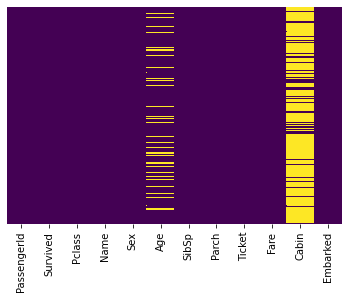

In [6]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap="viridis")

Around 20% of Age data is missing which is small enough to replace those missing values with new values.
In Cabin column we are just missing too much data, so we could drop this column or replace with a feature which shows whether Cabin is known or unknown.

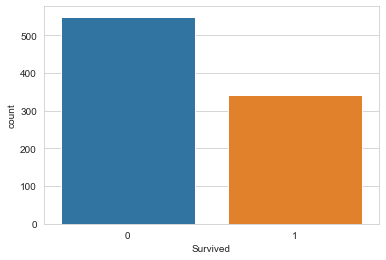

In [7]:
sns.set_style("whitegrid")
sns.countplot(x="Survived", data=df)

In [8]:
print("% of 0s : ", df["Survived"].value_counts().iloc[0] / len(df))
print("% of 1s : ", df["Survived"].value_counts().iloc[1] / len(df))

% of 0s :  0.6161616161616161
% of 1s :  0.3838383838383838


We can say that data is balanced.

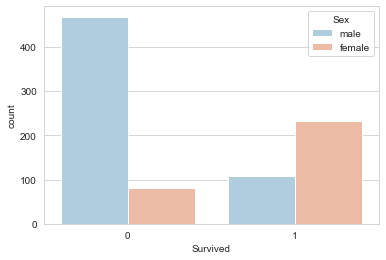

In [9]:
sns.set_style("whitegrid")
sns.countplot(x="Survived", hue="Sex", data=df, palette="RdBu_r")

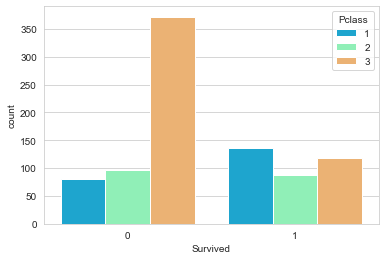

In [10]:
sns.set_style("whitegrid")
sns.countplot(x="Survived", hue="Pclass", data=df, palette="rainbow")

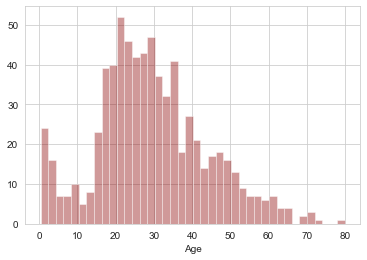

In [11]:
sns.distplot(df["Age"].dropna(), kde=False, color="darkred", bins=40)

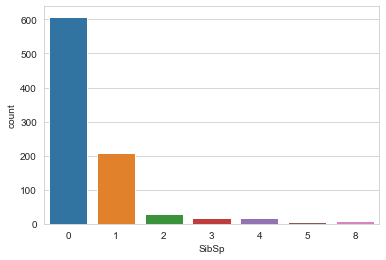

In [12]:
sns.countplot(x="SibSp", data=df)

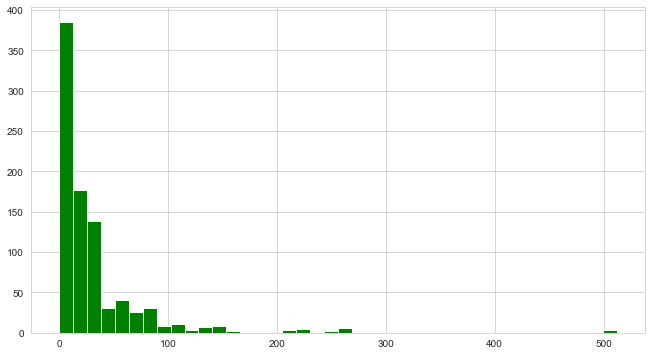

In [13]:
df["Fare"].hist(color="green", bins=40, figsize=(11,6))

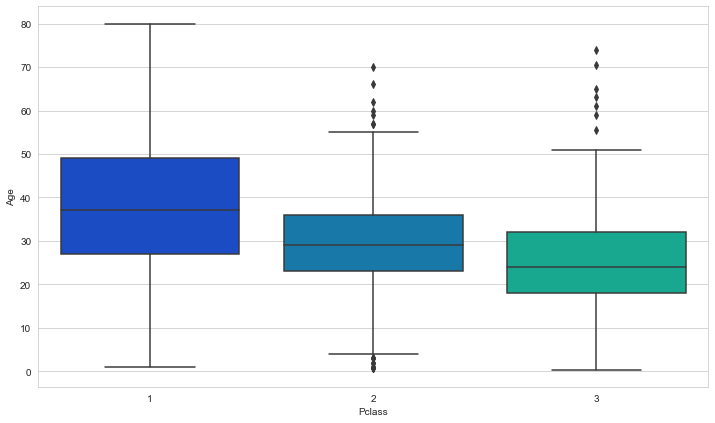

In [14]:
plt.figure(figsize=(12,7))
sns.boxplot(x="Pclass", y="Age", data=df, palette="winter")

As we there is a relationship between Pclass and Age. We can fill the missing values in Age column with the mean of all passengers or it would be better to fill the values with the average age of the corresponding Pclass.

In [15]:
def fun(row):
    age = row[0]
    pclass = row[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return 37
        elif pclass == 2:
            return 29
        else:
            return 24
    else:
        return age

In [16]:
df["Age"] = df[["Age", "Pclass"]].apply(fun, axis=1) # axis=1 means apply function to each row

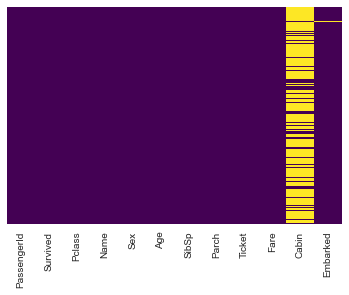

In [17]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap="viridis")

In [18]:
# Drop the cabin column
df.drop("Cabin", axis=1, inplace=True)

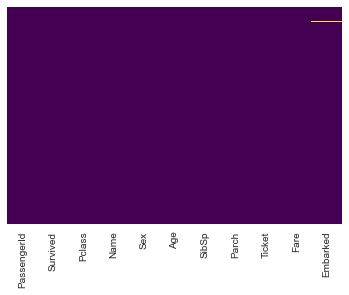

In [19]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap="viridis")

In [20]:
df.isna().sum()


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

As we see we still have some missing values in Embarked column

In [21]:
# Since there are only 2 missing values we are going to drop these 2 rows which have missing value of Embarked
df.dropna(inplace=True)

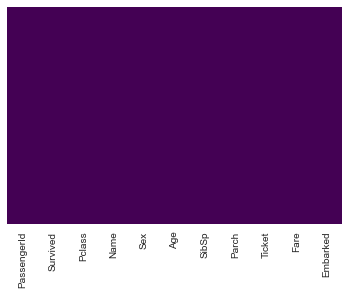

In [22]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap="viridis")

### Convert categories features to numerical

In [23]:
sex = pd.get_dummies(df["Sex"], drop_first=True)
embark = pd.get_dummies(df["Embarked"], drop_first=True)

In [24]:
df.drop(["PassengerId", "Sex", "Embarked", "Name", "Ticket"], axis=1, inplace=True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [25]:
df = pd.concat([df, sex, embark], axis=1)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [26]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [28]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [29]:
# Model Performance on TRAINING SET

train_pred = model.predict(x_train)
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       416
           1       1.00      0.96      0.98       250

    accuracy                           0.99       666
   macro avg       0.99      0.98      0.99       666
weighted avg       0.99      0.99      0.99       666



In [30]:
# Model performance on TEST set

test_pred = model.predict(x_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.72      0.79      0.76       133
           1       0.64      0.56      0.60        90

    accuracy                           0.70       223
   macro avg       0.68      0.67      0.68       223
weighted avg       0.69      0.70      0.69       223



In [31]:
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,32,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'splitter' : ['best', 'random']
    
}

In [32]:
# Hyperparameter tuning will increase the accuracy on test set

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid_param, cv=5, n_jobs =-1)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 32),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'splitter': ['best', 'random']})

In [34]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 6, 'splitter': 'random'}


In [36]:
grid_search.best_score_

0.8483335203680845

In [35]:
new_model = DecisionTreeClassifier(criterion="entropy", max_depth=11, min_samples_leaf=3, min_samples_split=6, splitter="random")
new_model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_leaf=3,
                       min_samples_split=6, splitter='random')

In [36]:
# Model Performance on TRAINING SET

train_pred = new_model.predict(x_train)
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       416
           1       0.89      0.74      0.81       250

    accuracy                           0.87       666
   macro avg       0.87      0.84      0.86       666
weighted avg       0.87      0.87      0.87       666



In [37]:
# Model performance on TEST set

test_pred = new_model.predict(x_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       133
           1       0.84      0.57      0.68        90

    accuracy                           0.78       223
   macro avg       0.80      0.75      0.75       223
weighted avg       0.79      0.78      0.77       223



In [38]:
import pickle
f1 = open("decision_tree.pickle", "wb")
pickle.dump(new_model, f1)